## Imports

In [13]:
import psycopg2
from psycopg2 import connect, OperationalError, errorcodes, errors
import numpy as np
import math
import sys
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy import stats as kl
import time

## Setting up ENV and GLOBAL variables

In [15]:
dbname = "census"
user = "envy"
host = "localhost"
password = ""
db_relation = "adult"
reference_dataset = db_relation
target_dataset = "target_dataset"


measure_attributes=['age','fnlwgt', 'education_num','capital_gain','capital_loss','hours_per_week']
groupby_attributes=['workclass','education','occupation','relationship','race','sex','native_country','salary']
aggregate_functions=['sum','avg','max','min','count']

# measure_attributes=['age','capital_gain','hours_per_week']
# groupby_attributes=['workclass','relationship','sex']
# aggregate_functions=['avg','count']

#Connecting with local db
try:
    conn = psycopg2.connect(f"dbname='{dbname}' user='{user}' host='{host}' password='{password}'")
    cur = conn.cursor()
    print ("Connection to database successful")
except OperationalError as err:
    print_psycopg2_exception(err)
    conn = None

#To get top k utility views
K = 5

Connection to database successful


## Util functions

In [16]:
def print_psycopg2_exception(err):
    # get details about the exception
    err_type, err_obj, traceback = sys.exc_info()

    # get the line number when exception occured
    line_num = traceback.tb_lineno
    
    # print the connect() error
    print (f"""\npsycopg2 ERROR: {err} on linu number: {line_num}""")
    print (f"""psycopg2 traceback: {traceback} -- type: {err_type}""")

    # psycopg2 extensions.Diagnostics object attribute
    print (f"""\nextensions.Diagnostics: {err.diag}""")

    # print the pgcode and pgerror exceptions
    print (f"""pgerror: {err.pgerror}""")
    print (f"""pgcode: {err.pgcode}""", "\n")
    
def get_cursor(conn):
    cur = conn.cursor()
    return cur

def get_all_views(groupby_attributes, measure_attributes, aggregate_functions):
    views = np.array(np.meshgrid(groupby_attributes, measure_attributes, aggregate_functions)).T.reshape(-1,3)
    return views

def get_aggregate_function_measure_attribute_combinations(measure_attributes, aggregate_functions):
    combinations = np.array(np.meshgrid(measure_attributes, aggregate_functions)).T.reshape(-1,2)
    return combinations

def get_combined_aggregate_query(groupby_attribute, measure_attributes, aggregate_functions, target_relation, reference_relation):
    aggregate_function_measure_attribute_combinations = get_aggregate_function_measure_attribute_combinations(measure_attributes, aggregate_functions)
    aggregate_function_measure_combined_string = ','.join([f'{combination[1]}({combination[0]})' for combination in aggregate_function_measure_attribute_combinations])
    target_query, reference_query = combined_aggregate_query_generator(groupby_attribute, aggregate_function_measure_combined_string, target_relation, reference_relation)    
    return target_query, reference_query

def combined_aggregate_query_generator(groupby_attribute, aggregate_function_measure_combined_string, target_relation, reference_relation):
    target_query = f"""SELECT {groupby_attribute}, {aggregate_function_measure_combined_string} FROM {target_relation} GROUP BY {groupby_attribute}"""
    reference_query = f"""SELECT {groupby_attribute}, {aggregate_function_measure_combined_string} FROM {reference_relation} GROUP BY {groupby_attribute}"""
    return target_query, reference_query
    
def basic_query_generator(groupby_attribute, measure_attribute, aggregate_function, target_relation, reference_relation):
    target_query = f"""SELECT {groupby_attribute}, {aggregate_function}({measure_attribute}) FROM {target_relation} GROUP BY {groupby_attribute}"""
    reference_query = f"""SELECT {groupby_attribute}, {aggregate_function}({measure_attribute}) FROM {reference_relation} GROUP BY {groupby_attribute}"""
    return target_query, reference_query

def phased_query_generator(groupby_attribute, measure_attribute, aggregate_function, target_relation, reference_relation, target_boundary, reference_boundary):
    target_query = f"""SELECT {groupby_attribute}, {aggregate_function}({measure_attribute}) 
                        FROM (SELECT * from {target_relation} offset {target_boundary[0]} row fetch next {target_boundary[1]} rows only) as X  
                        GROUP BY {groupby_attribute}"""
    
    reference_query = f"""SELECT {groupby_attribute}, {aggregate_function}({measure_attribute}) 
                        FROM (SELECT * from {reference_relation} offset {reference_boundary[0]} row fetch next {reference_boundary[1]} rows only) as X  
                        GROUP BY {groupby_attribute}"""
    
    return target_query, reference_query

def get_phased_combined_aggregate_query(groupby_attribute, measure_attribute_aggregate_function_combinations, target_relation, reference_relation, target_boundary, reference_boundary):
    aggregate_function_measure_combined_string = ','.join([f'{combination[1]}({combination[0]})' for combination in measure_attribute_aggregate_function_combinations])
    target_query, reference_query = phased_combined_query_generator(groupby_attribute, aggregate_function_measure_combined_string, target_relation, reference_relation, target_boundary, reference_boundary)
    return target_query, reference_query

def phased_combined_query_generator(groupby_attribute, aggregate_function_measure_combined_string, target_relation, reference_relation, target_boundary, reference_boundary):
    target_query = f"""SELECT {groupby_attribute}, {aggregate_function_measure_combined_string} 
                        FROM (SELECT * from {target_relation} offset {target_boundary[0]} row fetch next {target_boundary[1]} rows only) as X  
                        GROUP BY {groupby_attribute}"""
    
    reference_query = f"""SELECT {groupby_attribute}, {aggregate_function_measure_combined_string} 
                        FROM (SELECT * from {reference_relation} offset {reference_boundary[0]} row fetch next {reference_boundary[1]} rows only) as X  
                        GROUP BY {groupby_attribute}"""
    
    return target_query, reference_query
    

def execute_get_query(cursor, query):
    try:
        cursor.execute(query)
    except Exception as err:
        print_psycopg2_exception(err)
        conn = None
        
    rows = cursor.fetchall()
    return rows

def get_key_based_values(target_result, reference_result):
    key_set = set()
    target_result_dict = {}
    reference_result_dict = {}
    final_target_values = []
    final_reference_values = []
    
    for key, value in target_result:
        key_set.add(key)
        target_result_dict[key] = float(value)
        
    for key, value in reference_result:
        key_set.add(key)
        reference_result_dict[key] = float(value)
        
    for key in key_set:
        final_target_values.append(target_result_dict.get(key, float(10e-20)) if target_result_dict.get(key, float(10e-20)) != 0.0 else float(10e-20))
        final_reference_values.append(reference_result_dict.get(key, float(10e-20)) if reference_result_dict.get(key, float(10e-20)) != 0.0 else float(10e-20))
        
    return final_target_values, final_reference_values
    
def get_valid_gropby_value(group_by_value):
    if group_by_value == 0.0:
        group_by_value = float(10e-20)
    return float(group_by_value)
    
def get_aggregate_function_measure_attribute_based_values(target_result, reference_result, aggregate_function_measure_attribute_combinations):
    """
    query example: SELECT workclass, avg(age),count(age),avg(capital_gain),count(capital_gain),avg(hours_per_week),count(hours_per_week) FROM target_dataset GROUP BY workclass
    target_result example:
    [('Self-emp-not-inc', Decimal('43.0000000000000000'), 1, Decimal('0E-20'), 1, Decimal('45.0000000000000000'), 1), 
    ('Private', Decimal('48.3333333333333333'), 3, Decimal('0E-20'), 3, Decimal('33.3333333333333333'), 3)]
    """
    key_set = set()
    target_result_dict = {}
    reference_result_dict = {}
    final_target_values = []
    final_reference_values = []
    no_combinations = len(aggregate_function_measure_attribute_combinations)
    combination_value_dict = {}
    
    for values in target_result:
        key_set.add(values[0])
        target_result_dict[values[0]] = list(map(get_valid_gropby_value, values[1:]))
        
    for values in reference_result:
        key_set.add(values[0])
        reference_result_dict[values[0]] = list(map(get_valid_gropby_value, values[1:]))
        
    for i, combination in enumerate(aggregate_function_measure_attribute_combinations):
        combination = tuple(combination)
        combination_value_dict[combination] = {"target_values":[], "reference_values":[]}
        for key in key_set:
            target_value = target_result_dict.get(key, [float(10e-20)]*no_combinations)[i]
            reference_value = reference_result_dict.get(key, [float(10e-20)]*no_combinations)[i]
            
            combination_value_dict[combination]["target_values"].append(target_value)
            combination_value_dict[combination]["reference_values"].append(reference_value)
            
    return combination_value_dict

def get_aggregate_function_measure_attribute_based_KL_divergence(aggregate_function_measure_attribute_based_values):
    kl_divergence_dict = {}
    for aggregate_function_measure_attribute_pair in aggregate_function_measure_attribute_based_values:
        target_vector = aggregate_function_measure_attribute_based_values[aggregate_function_measure_attribute_pair]['target_values']
        reference_vector = aggregate_function_measure_attribute_based_values[aggregate_function_measure_attribute_pair]['reference_values']
        kl_divergence_dict[aggregate_function_measure_attribute_pair] = calculate_kl_divergence(target_vector, reference_vector)
        
    return kl_divergence_dict
        
def calculate_kl_divergence(vector1, vector2):
    #print("With manual code", sum(vector1[i] * math.log2(vector1[i]/vector2[i]) for i in range(len(vector1))))
    #print("With kl library", kl.entropy(vector1,vector2))
    return sum(vector1[i] * math.log2(vector1[i]/vector2[i]) for i in range(len(vector1)))
#     return kl.entropy(vector1,vector2)

def basic_get_top_k_utility_views(kl_divergence_view_mapping_list, k):
    top_k_views = [view for kl_divergence, view in sorted(kl_divergence_view_mapping_list)[0:k]]
    return top_k_views

def phased_get_top_k_utility_views(kl_divergence_view_mapping, k):
    sorted_items = sorted(kl_divergence_view_mapping.items(), key=lambda kv: np.mean(kv[1]), reverse=True)[0:k]
    return [item[0] for item in sorted_items]

def get_phase_partitions(total_rows, phases):
    return [total_rows // phases + (1 if x < total_rows % phases else 0) for x in range (phases)]


## Getting user input and setting the target_db

In [4]:
#test_query = select * from adult where relationship =' Unmarried'; 
try:
    attribute_value_input = input("Enter the attribute and associative value for the where clause seperated by space.")
    attribute, value = attribute_value_input.split(" ")
    query = f"select * from adult where {attribute} = '{value}'" 
    #cur = get_cursor(conn)
    cur.execute(f"""DROP table IF EXISTS {target_dataset};""")
    print(f"""Target dataset create command: create table {target_dataset} as {query};""")
    cur.execute(f"""create table {target_dataset} as {query};""")
    conn.commit()
    print(f"Creation of target table successfull.")
except Exception as err:
    print("Error in establishing target db")
    print_psycopg2_exception(err)
    conn = None
    
print(f"The reference dataset is {reference_dataset}")

Enter the attribute and associative value for the where clause seperated by space. marital_status Married


Target dataset create command: create table target_dataset as select * from adult where marital_status = 'Married';
Creation of target table successfull.
The reference dataset is adult


## Get all views

In [17]:
views = get_all_views(groupby_attributes, measure_attributes, aggregate_functions)
print("Total views at start for consideration", len(views))

Total views at start for consideration 240


## Basic Implementation (Don't need to run)

In [18]:
def basic_implementation(views):
    kl_divergence_view_mapping_list = []
    for groupby_attribute, measure_attribute, aggregate_function in views:
        target_query, reference_query = basic_query_generator(groupby_attribute, measure_attribute, aggregate_function, target_dataset, reference_dataset)
        target_result = execute_get_query(get_cursor(conn), target_query)
        reference_result = execute_get_query(get_cursor(conn), reference_query)
        target_values, reference_values = get_key_based_values(target_result, reference_result)
        kl_divergence = calculate_kl_divergence(target_values, reference_values)
        kl_divergence_view_mapping_list.append((kl_divergence, (groupby_attribute, measure_attribute, aggregate_function)))
    
    return kl_divergence_view_mapping_list

starttime = time.time()
kl_divergence_view_mapping_list = basic_implementation(views)
top_k_views = basic_get_top_k_utility_views(kl_divergence_view_mapping_list,  K)
print(time.time() - starttime)
print(top_k_views)

3.254664182662964
[('native_country', 'fnlwgt', 'sum'), ('race', 'fnlwgt', 'sum'), ('education', 'fnlwgt', 'sum'), ('workclass', 'fnlwgt', 'sum'), ('occupation', 'fnlwgt', 'sum')]


## Shared Optimization on Basic (Don't need to run)

In [20]:
kl_divergence_view_mapping_list = []
aggregate_function_measure_attribute_combinations = get_aggregate_function_measure_attribute_combinations(measure_attributes, aggregate_functions)
for groupby_attribute in groupby_attributes:
    target_query, reference_query = get_combined_aggregate_query(groupby_attribute, measure_attributes, aggregate_functions, target_dataset, reference_dataset)
    target_result = execute_get_query(get_cursor(conn), target_query)
    reference_result = execute_get_query(get_cursor(conn), reference_query)
    aggregate_function_measure_attribute_based_values = get_aggregate_function_measure_attribute_based_values(target_result, reference_result, aggregate_function_measure_attribute_combinations)
    aggregate_function_measure_attribute_based_KL_divergence = get_aggregate_function_measure_attribute_based_KL_divergence(aggregate_function_measure_attribute_based_values)
    for aggregate_function_measure_attribute_pair in aggregate_function_measure_attribute_based_KL_divergence:
        kl_divergence = aggregate_function_measure_attribute_based_KL_divergence[aggregate_function_measure_attribute_pair]
        kl_divergence_view_mapping_list.append((kl_divergence, (groupby_attribute, aggregate_function_measure_attribute_pair[0], aggregate_function_measure_attribute_pair[1])))

starttime = time.time()      
kl_divergence_view_mapping_list = basic_implementation(views)
top_k_views = basic_get_top_k_utility_views(kl_divergence_view_mapping_list,  K)
print(time.time() - starttime)
print(top_k_views)

3.1422042846679688
[('native_country', 'fnlwgt', 'sum'), ('race', 'fnlwgt', 'sum'), ('education', 'fnlwgt', 'sum'), ('workclass', 'fnlwgt', 'sum'), ('occupation', 'fnlwgt', 'sum')]


## Phased Implementation with Shared & Pruning Optimization

### Hyperparameters

In [7]:
num_phases = 3
delta = 0.1  # probability bound

In [8]:
##Map view->kl divergence list
def phased_implementation(views):
    target_dataset_rows = execute_get_query(get_cursor(conn), f"""select count(*) from {target_dataset};""")[0][0]
    reference_dataset_rows = execute_get_query(get_cursor(conn), f"""select count(*) from {reference_dataset};""")[0][0]
    target_dataset_partitions = get_phase_partitions(target_dataset_rows, num_phases)
    reference_dataset_partitions = get_phase_partitions(reference_dataset_rows, num_phases)

    # 13, 33
    # 13 -> 5, 4, 4 [1, 2, 3, 4, 5], [6, 7, 8, 9], [10, 11, 12, 13]
    # 33 -> 11, 11, 11
    target_start = reference_start = 0
    kl_divergence_view_mapping = defaultdict(list)
    
    aggregate_function_measure_attribute_combinations = get_aggregate_function_measure_attribute_combinations(measure_attributes, aggregate_functions)
    #print(f"The combinations are {aggregate_function_measure_attribute_combinations}")
    groupby_attribute_combination_mapping = {}
    
    for groupby_attribute in groupby_attributes:
        groupby_attribute_combination_mapping[groupby_attribute] = set([(combination[0], combination[1]) for combination in aggregate_function_measure_attribute_combinations])
    
    #print(groupby_attribute_combination_mapping)
    
    for phase in range(num_phases):
        #print(f"Phase {phase}")
        #print(f"groupby_attribute_combination_mapping => {groupby_attribute_combination_mapping}")
        
        target_offset = target_dataset_partitions[phase]
        reference_offset = reference_dataset_partitions[phase]
        
        for groupby_attribute in groupby_attribute_combination_mapping.keys():
            #print(f"Processing groupby attribute {groupby_attribute}")
            ##For fixing the combination place in the list
            measure_attribute_aggregate_function_combinations = list(groupby_attribute_combination_mapping[groupby_attribute])
            target_query, reference_query = get_phased_combined_aggregate_query(groupby_attribute, \
                                                                            measure_attribute_aggregate_function_combinations, \
                                                                            target_dataset, \
                                                                            reference_dataset, \
                                                                            [target_start, target_offset], \
                                                                            [reference_start, reference_offset])
            #print(f"target query => {target_query}")
            
            target_result = execute_get_query(get_cursor(conn), target_query)
            reference_result = execute_get_query(get_cursor(conn), reference_query)
            
            aggregate_function_measure_attribute_based_values = get_aggregate_function_measure_attribute_based_values(target_result, reference_result, measure_attribute_aggregate_function_combinations)
            aggregate_function_measure_attribute_based_KL_divergence = get_aggregate_function_measure_attribute_based_KL_divergence(aggregate_function_measure_attribute_based_values)
            
            #print(f"The KL divergence mapping for groupby attribute {groupby_attribute} => {aggregate_function_measure_attribute_based_KL_divergence}")
            
            for aggregate_function_measure_attribute_pair in aggregate_function_measure_attribute_based_KL_divergence:
                kl_divergence = aggregate_function_measure_attribute_based_KL_divergence[aggregate_function_measure_attribute_pair]
                kl_divergence_view_mapping[(groupby_attribute, aggregate_function_measure_attribute_pair[0], aggregate_function_measure_attribute_pair[1])].append(kl_divergence)
            
        # ignore first phase for view dropping
        if phase > 0:
            m = phase + 1
            N = num_phases                
                
            # calculation of confidence interval em
            numerator = (1-(m-1)/N)*(2*np.log10(np.log10(m))) + np.log10((np.pi)**2/3/delta)
            em = np.sqrt(numerator/2/m)

            # find top k views sorting by decreasing upper bound
            current_view_scores = [(k, v) for k, v in kl_divergence_view_mapping.items()]
            views_ranking = sorted(current_view_scores, key=lambda x: np.mean(x[1]), reverse=True)
            
            # smallest lower bound of top k views
            top_k_smallest_lower_bound = np.mean(views_ranking[K][1]) - em            
            
            # dropping the views
            for view in list(kl_divergence_view_mapping.keys()):
                if np.mean(kl_divergence_view_mapping[view])+em < top_k_smallest_lower_bound:
                    del kl_divergence_view_mapping[view]
                    groupby_attribute_combination_mapping[view[0]].remove((view[1], view[2]))
                    if len(groupby_attribute_combination_mapping[view[0]]) == 0:
                        del groupby_attribute_combination_mapping[view[0]]
            
        target_start += target_offset
        reference_start += reference_offset
        
    return kl_divergence_view_mapping

## Final Result

In [21]:
starttime = time.time()
kl_divergence_view_mapping = phased_implementation(views)
top_k_views = phased_get_top_k_utility_views(kl_divergence_view_mapping,  K)
print(time.time() - starttime)
top_k_views

0.3007988929748535


[('native_country', 'fnlwgt', 'min'),
 ('education', 'fnlwgt', 'min'),
 ('occupation', 'fnlwgt', 'min'),
 ('race', 'fnlwgt', 'min'),
 ('native_country', 'capital_loss', 'min')]

## Plotting

native_country fnlwgt min
SELECT native_country, min(fnlwgt) FROM target_dataset GROUP BY native_country
SELECT native_country, min(fnlwgt) FROM adult GROUP BY native_country
[('Italy', 37913), ('Ecuador', 126569), ('Columbia', 100662), ('Hungary', 122066), ('Trinadad&Tobago', 53042), ('Puerto-Rico', 39827), ('China', 35021), ('United-States', 13769), ('Hong', 119628), ('Honduras', 51835), ('Scotland', 89813), ('South', 32519), ('Ireland', 90414), ('Guatemala', 118861), ('Germany', 34845), ('Cambodia', 63685), ('Outlying-US(Guam-USVI-etc)', 172828), ('Laos', 97411), ('Canada', 33365), ('Portugal', 60668), ('Cuba', 120131), ('England', 19302), ('Greece', 62539), ('India', 31740), ('Iran', 52327), ('France', 29235), ('El-Salvador', 44368), ('Vietnam', 52028), ('Nicaragua', 161334), ('Mexico', 36383), ('Peru', 147322), ('Taiwan', 27494), ('Poland', 98611), ('Yugoslavia', 81280), ('Japan', 22201), ('Haiti', 82285), ('Dominican-Republic', 39014), ('Philippines', 14878), ('Jamaica', 78356), 

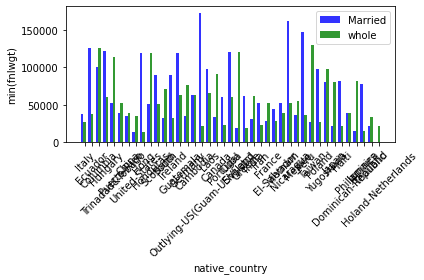

education fnlwgt min
SELECT education, min(fnlwgt) FROM target_dataset GROUP BY education
SELECT education, min(fnlwgt) FROM adult GROUP BY education
[('Assoc-voc', 22245), ('10th', 24153), ('HS-grad', 19899), ('Preschool', 98350), ('1st-4th', 52028), ('Masters', 20179), ('5th-6th', 45508), ('Bachelors', 19302), ('11th', 22313), ('12th', 29152), ('Assoc-acdm', 19302), ('Doctorate', 22245), ('7th-8th', 22907), ('Some-college', 13769), ('9th', 24515), ('Prof-school', 14878)]
[('Assoc-voc', 20098), ('10th', 21698), ('HS-grad', 19214), ('Preschool', 69911), ('1st-4th', 34378), ('Masters', 20179), ('5th-6th', 32896), ('Bachelors', 19302), ('11th', 19752), ('12th', 23037), ('Assoc-acdm', 19302), ('Doctorate', 19520), ('7th-8th', 20057), ('Some-college', 13769), ('9th', 22418), ('Prof-school', 14878)]
dict {'Assoc-voc': 20098, '10th': 21698, 'HS-grad': 19214, 'Preschool': 69911, '1st-4th': 34378, 'Masters': 20179, '5th-6th': 32896, 'Bachelors': 19302, '11th': 19752, '12th': 23037, 'Assoc-acdm

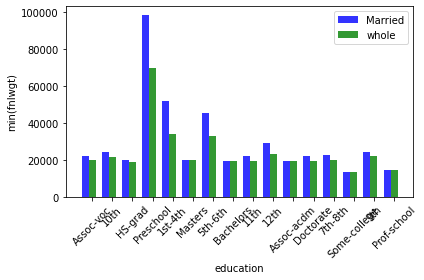

occupation fnlwgt min
SELECT occupation, min(fnlwgt) FROM target_dataset GROUP BY occupation
SELECT occupation, min(fnlwgt) FROM adult GROUP BY occupation
[('Sales', 20333), ('Machine-op-inspct', 13769), ('Farming-fishing', 20795), ('Craft-repair', 19899), ('Exec-managerial', 19914), ('Handlers-cleaners', 19395), ('Prof-specialty', 14878), ('Tech-support', 20179), ('Transport-moving', 20795), ('Adm-clerical', 19914), ('Priv-house-serv', 24384), ('Other-service', 19914), ('Protective-serv', 19302), ('Armed-Forces', 76313)]
[('Sales', 19410), ('Machine-op-inspct', 13769), ('Farming-fishing', 20795), ('Craft-repair', 19491), ('Exec-managerial', 19914), ('Handlers-cleaners', 19214), ('Prof-specialty', 14878), ('Tech-support', 19847), ('Transport-moving', 18827), ('Adm-clerical', 19302), ('Priv-house-serv', 24384), ('Other-service', 19752), ('Protective-serv', 19302), ('Armed-Forces', 76313)]
dict {'Sales': 19410, 'Machine-op-inspct': 13769, 'Farming-fishing': 20795, 'Craft-repair': 19491, 

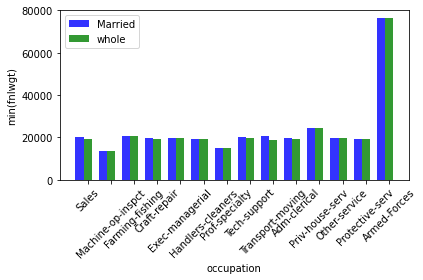

race fnlwgt min
SELECT race, min(fnlwgt) FROM target_dataset GROUP BY race
SELECT race, min(fnlwgt) FROM adult GROUP BY race
[('Black', 23494), ('Asian-Pac-Islander', 14878), ('Other', 25610), ('Amer-Indian-Eskimo', 13769), ('White', 19302)]
[('Black', 19752), ('Asian-Pac-Islander', 14878), ('Other', 24562), ('Amer-Indian-Eskimo', 13769), ('White', 18827)]
dict {'Black': 19752, 'Asian-Pac-Islander': 14878, 'Other': 24562, 'Amer-Indian-Eskimo': 13769, 'White': 18827}


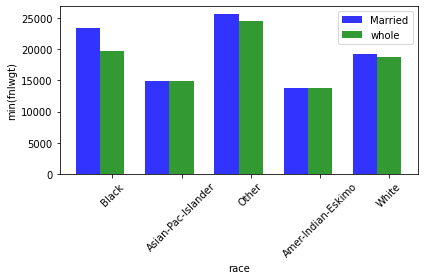

native_country capital_loss min
SELECT native_country, min(capital_loss) FROM target_dataset GROUP BY native_country
SELECT native_country, min(capital_loss) FROM adult GROUP BY native_country
[('Italy', 0), ('Ecuador', 0), ('Columbia', 0), ('Hungary', 0), ('Trinadad&Tobago', 0), ('Puerto-Rico', 0), ('China', 0), ('United-States', 0), ('Hong', 0), ('Honduras', 0), ('Scotland', 0), ('South', 0), ('Ireland', 0), ('Guatemala', 0), ('Germany', 0), ('Cambodia', 0), ('Outlying-US(Guam-USVI-etc)', 0), ('Laos', 0), ('Canada', 0), ('Portugal', 0), ('Cuba', 0), ('England', 0), ('Greece', 0), ('India', 0), ('Iran', 0), ('France', 0), ('El-Salvador', 0), ('Vietnam', 0), ('Nicaragua', 0), ('Mexico', 0), ('Peru', 0), ('Taiwan', 0), ('Poland', 0), ('Yugoslavia', 0), ('Japan', 0), ('Haiti', 0), ('Dominican-Republic', 0), ('Philippines', 0), ('Jamaica', 0), ('Thailand', 0)]
[('Holand-Netherlands', 2205), ('Italy', 0), ('Ecuador', 0), ('Columbia', 0), ('Hungary', 0), ('Trinadad&Tobago', 0), ('Puerto-Ric

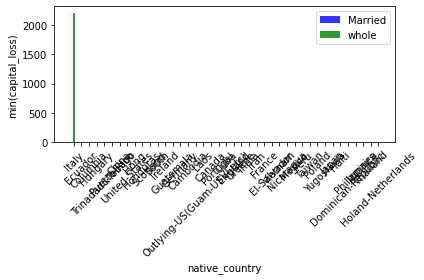

In [22]:
for a, m, f in top_k_views:
    # get target and reference data
    target_query, reference_query = basic_query_generator(a, m, f, target_dataset, reference_dataset)
    #print(target_query, reference_query)
    target_result = execute_get_query(get_cursor(conn), target_query)
    reference_result = execute_get_query(get_cursor(conn), reference_query)
    print(a,m,f)
    print(target_query)
    print(reference_query)
    print(target_result)
    print(reference_result)
    print('dict', dict(reference_result))

    # create plot
    fig, ax = plt.subplots()
    bar_width = 0.35
    opacity = 0.8

    tgt_dict = dict(target_result)
    ref_dict = dict(reference_result)

    for k in tgt_dict.keys():
        if k not in ref_dict:
            ref_dict[k] = 0

    for k in ref_dict.keys():
        if k not in tgt_dict:
            tgt_dict[k] = 0


    index = np.arange(len(tgt_dict))
    rects1 = plt.bar(index, tgt_dict.values(), bar_width,
                     alpha=opacity,
                     color='b',
                     label=value)

    rects2 = plt.bar(index + bar_width, ref_dict.values(), bar_width,
                     alpha=opacity,
                     color='g',
                     label="whole")

    plt.xlabel('{}'.format(a))
    plt.ylabel('{}({})'.format(f, m))
    plt.xticks(index + bar_width, tgt_dict.keys(), rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()